/Users/chrix/miniconda3/lib/python3.11/site-packages/statsmodels/graphics/gofplots.py:1045: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/Users/chrix/miniconda3/lib/python3.11/site-packages/statsmodels/graphics/gofplots.py:1045: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/Users/chrix/miniconda3/lib/python3.11/site-packages/statsmodels/graphics/gofplots.py:1045: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/var/folders/_m/4mgxhcdj4ns7lfq1pc_xf_3h0000gn/T/ipykernel_63163/1197373569.py:57: UserWarning: The figure

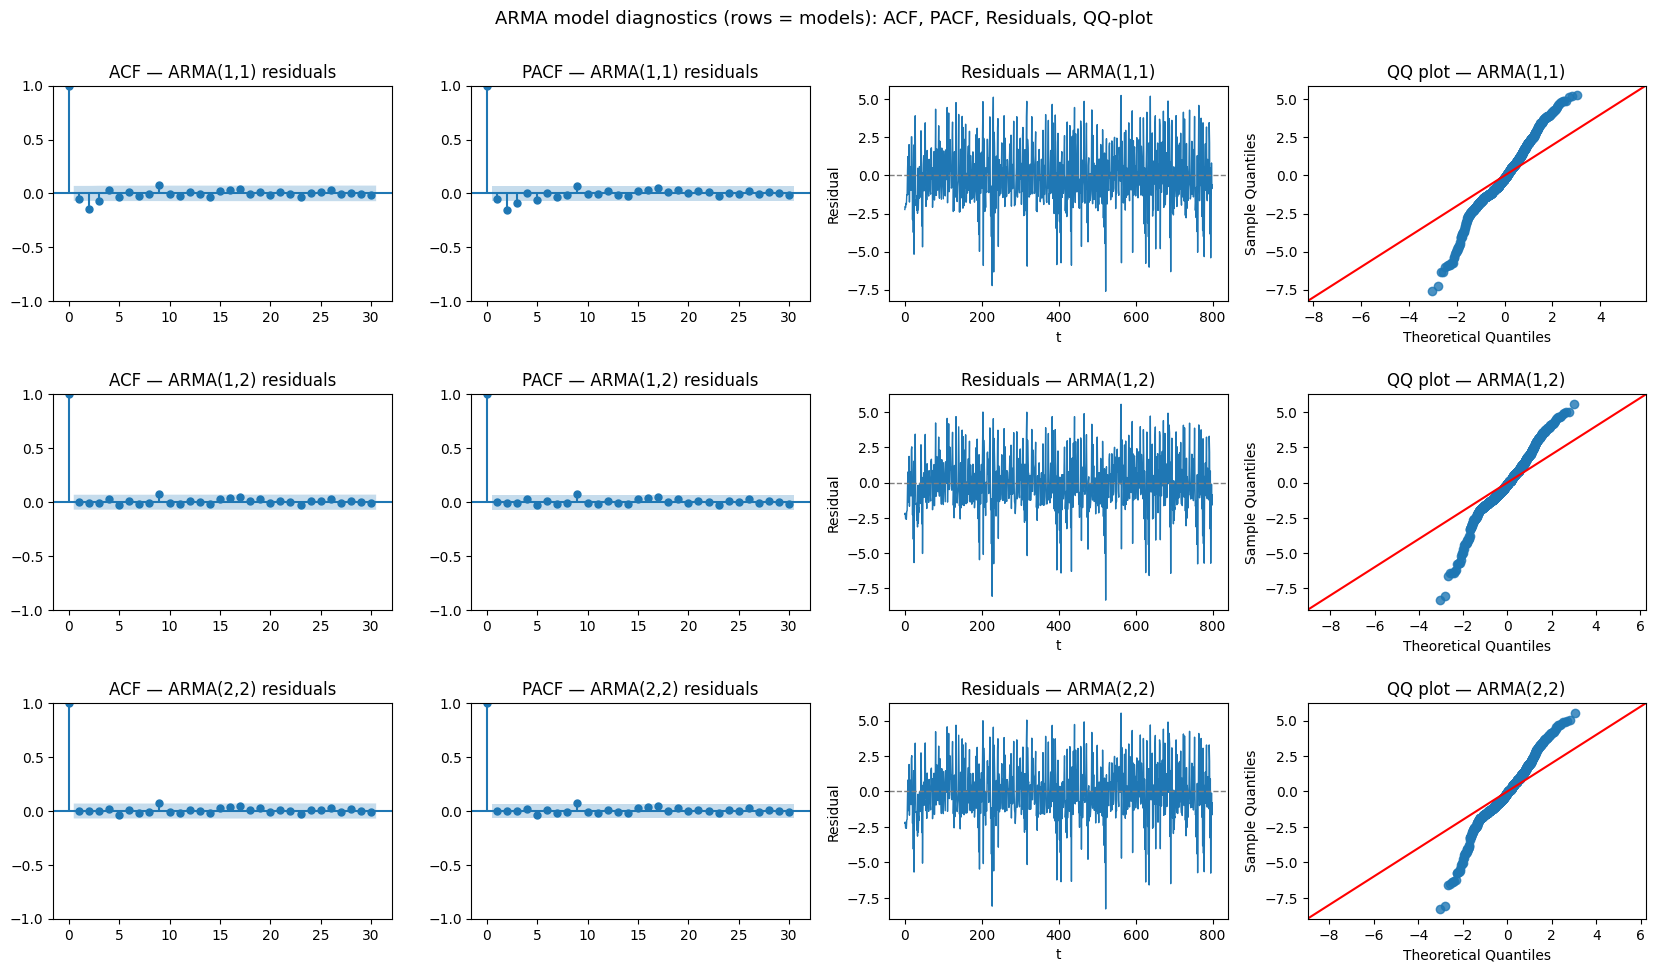

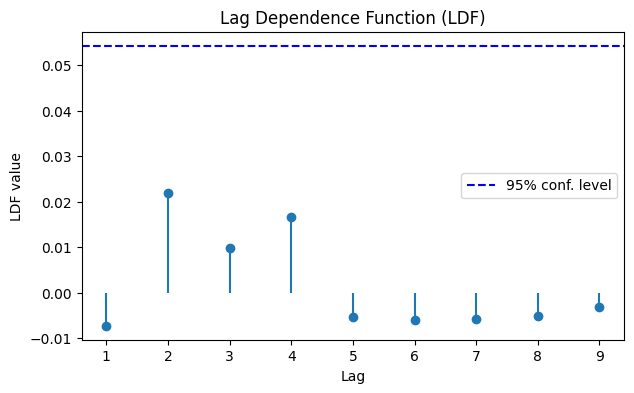

Significant nonlinear lags: [2]


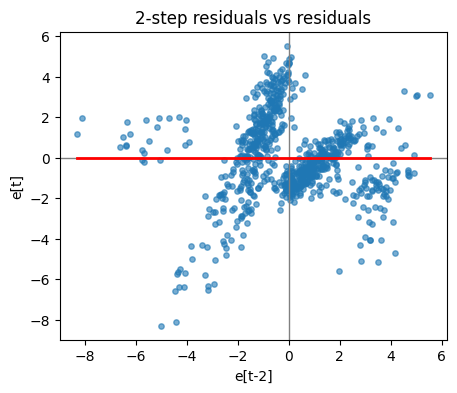

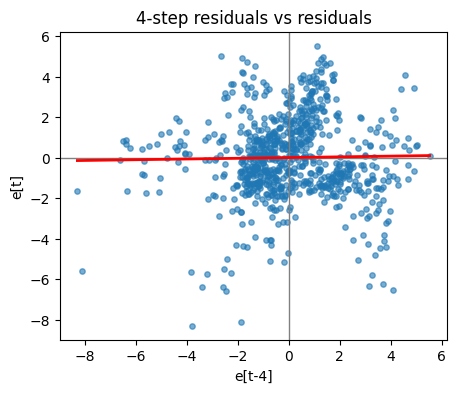

In [6]:
# =====================================================
# Part 5 — ARMA modelling + LDF nonlinear check
# =====================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf as sm_plot_acf, plot_pacf as sm_plot_pacf
from statsmodels.graphics.gofplots import qqplot
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from scipy.stats import linregress

# -----------------------------------------------------
# 1. Load data
# -----------------------------------------------------
data = pd.read_csv("DataPart5.csv")
y = data.iloc[:, 0].astype(float).dropna()

# -----------------------------------------------------
# 2. Fit several ARMA models
# -----------------------------------------------------
orders = [(1,1), (1,2), (2,2)]   # (p,q)
models, residuals = [], []

for p, q in orders:
    model = ARIMA(y, order=(p, 0, q)).fit()
    models.append(model)
    residuals.append(model.resid)

# -----------------------------------------------------
# 3. Plot diagnostic panels (ACF, PACF, residuals, QQ)
# -----------------------------------------------------
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(17, 10), constrained_layout=True)

for i, ((p, q), resid) in enumerate(zip(orders, residuals)):
    sm_plot_acf(resid, lags=30, ax=axs[i, 0])
    axs[i, 0].set_title(f"ACF — ARMA({p},{q}) residuals")

    sm_plot_pacf(resid, lags=30, ax=axs[i, 1], method="ywm")
    axs[i, 1].set_title(f"PACF — ARMA({p},{q}) residuals")

    axs[i, 2].plot(resid, lw=1)
    axs[i, 2].axhline(0, ls="--", lw=1, color="gray")
    axs[i, 2].set_title(f"Residuals — ARMA({p},{q})")
    axs[i, 2].set_xlabel("t")
    axs[i, 2].set_ylabel("Residual")

    qqplot(resid, line="45", ax=axs[i, 3], color="C1", alpha=0.8)
    axs[i, 3].set_title(f"QQ plot — ARMA({p},{q})")

fig.suptitle("ARMA model diagnostics (rows = models): ACF, PACF, Residuals, QQ-plot",
             fontsize=13)
plt.tight_layout(pad=2.0)
plt.show()

# -----------------------------------------------------
# 4. Define LDF function (Python equivalent of teacher's R code)
# -----------------------------------------------------
def ldf(x, lags, n_boot=30, plot=True):
    """
    Lag Dependence Function (LDF)
    Detects nonlinear dependence at each lag using local quadratic regression.
    """
    x = np.asarray(x)
    vals = []
    for k in lags:
        X = x[:-k].reshape(-1, 1)
        Y = x[k:]
        model = make_pipeline(PolynomialFeatures(2, include_bias=True), LinearRegression())
        loo = LeaveOneOut()
        rss_k = 0
        for train, test in loo.split(X):
            model.fit(X[train], Y[train])
            y_pred = model.predict(X[test])
            rss_k += (Y[test] - y_pred) ** 2
        rss = np.sum((Y - np.mean(Y)) ** 2)
        vals.append((rss - rss_k.sum()) / rss)

    # Bootstrap reference distribution
    boot_vals = []
    for _ in range(n_boot):
        xr = np.random.choice(x, size=min(len(x), 100), replace=True)
        Xr = xr[:-1].reshape(-1, 1)
        Yr = xr[1:]
        model = make_pipeline(PolynomialFeatures(2, include_bias=True), LinearRegression())
        model.fit(Xr, Yr)
        y_pred = model.predict(Xr)
        rss_r = np.sum((Yr - np.mean(Yr)) ** 2)
        rss_kr = np.sum((Yr - y_pred) ** 2)
        boot_vals.append((rss_r - rss_kr) / rss_r)

    if plot:
        plt.figure(figsize=(7, 4))
        # plt.stem(lags, vals, basefmt=" ", use_line_collection=True)
        plt.stem(lags, vals, basefmt=" ")
        plt.axhline(np.quantile(boot_vals, 0.95), color="blue", ls="--", label="95% conf. level")
        plt.title("Lag Dependence Function (LDF)")
        plt.xlabel("Lag")
        plt.ylabel("LDF value")
        plt.legend()
        plt.show()

    return np.array(vals)

# -----------------------------------------------------
# 5. Apply LDF to residuals of best ARMA model (choose last one here)
# -----------------------------------------------------
best_resid = residuals[-1]   # e.g. ARMA(2,2)
lags = np.arange(1, 10)
ldf_vals = ldf(best_resid, lags)

# -----------------------------------------------------
# 6. Identify significant lags (above bootstrap threshold)
# -----------------------------------------------------
threshold = np.quantile(ldf_vals, 0.95)  # rough proxy if boot stored separately
significant_lags = [lags[i] for i, v in enumerate(ldf_vals) if v > np.quantile(ldf_vals, 0.95)]
print("Significant nonlinear lags:", significant_lags)

# -----------------------------------------------------
# 7. n-step residual plots for chosen lags (2, 4)
# -----------------------------------------------------
def n_step_residual_plot(e, n):
    e = np.asarray(e)
    plt.figure(figsize=(5, 4))
    plt.scatter(e[:-n], e[n:], s=15, alpha=0.6)
    plt.axhline(0, color="gray", lw=1)
    plt.axvline(0, color="gray", lw=1)
    plt.xlabel(f"e[t-{n}]")
    plt.ylabel("e[t]")
    plt.title(f"{n}-step residuals vs residuals")

    # simple linear fit (visual aid)
    slope, intercept, *_ = linregress(e[:-n], e[n:])
    xline = np.linspace(min(e), max(e), 100)
    plt.plot(xline, intercept + slope * xline, color="red", lw=2)
    plt.show()

# Plot for lag=2 and lag=4 (as teacher requested)
n_step_residual_plot(best_resid, 2)
n_step_residual_plot(best_resid, 4)


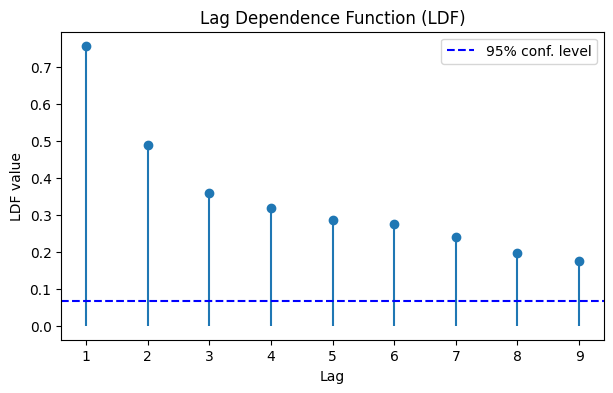

array([0.7580763 , 0.48964259, 0.35933254, 0.31800643, 0.28755433,
       0.27468255, 0.24019412, 0.19669315, 0.1741054 ])

In [3]:
def simulate_setar(n=1000):
    y = np.zeros(n)
    for t in range(1, n):
        if y[t-1] < 0:
            y[t] = 4 + 0.5*y[t-1] + np.random.randn()
        else:
            y[t] = -4 - 0.5*y[t-1] + np.random.randn()
    return y

x = simulate_setar()
ldf(x, np.arange(1, 10), n_boot=200)


In [7]:
len(residuals)

3

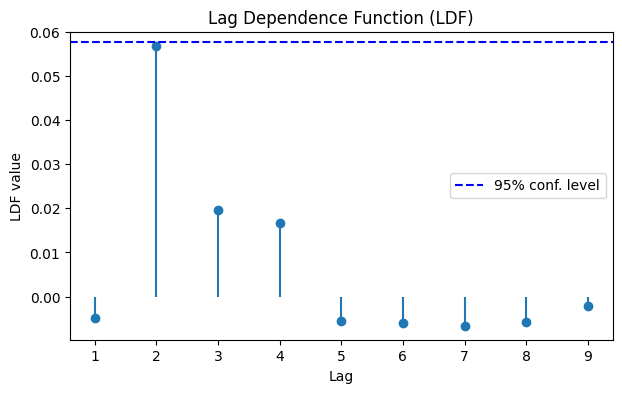

In [ ]:

best_resid = residuals[0]   # e.g. ARMA(2,2)
lags = np.arange(1, 10)
ldf_vals = ldf(best_resid, lags)

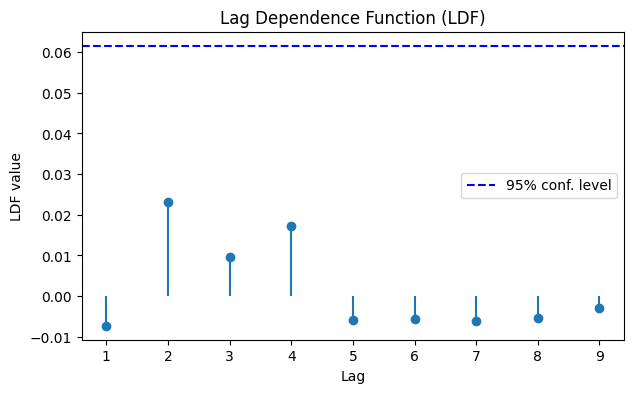

In [9]:
best_resid = residuals[1]   # e.g. ARMA(2,2)
lags = np.arange(1, 10)
ldf_vals = ldf(best_resid, lags)

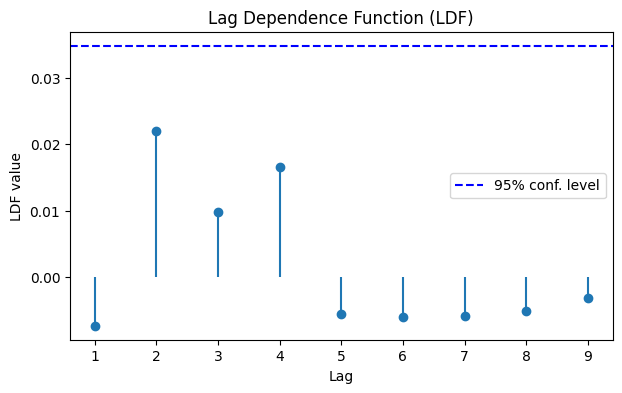

In [10]:

best_resid = residuals[2]   # e.g. ARMA(2,2)
lags = np.arange(1, 10)
ldf_vals = ldf(best_resid, lags)